In [73]:
import pandas as pd
import numpy as np
import os
import numpy
import matplotlib.pyplot as plt
import SimpleITK
import itertools
import sys
import torch
from torchvision import transforms
from PIL import Image
from matplotlib import cm
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision import models
from src.loading import get_dataloader_single_folder

from pathlib import Path

SOURCE_PATH = Path(os.getcwd()) / 'src'

if SOURCE_PATH not in sys.path:
    sys.path.append(SOURCE_PATH)

from src.extraction import (
    export_all_images_jpeg,
    export_images_list_jpeg,
    get_images_lists_from_path,
    get_images_lists_from_more_paths
)

from src.plots import (
    plot_observation
)

from src.modelling import (
    train_model
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
hgg = Path(os.getcwd()) / 'data' / 'HGG'
lgg = Path(os.getcwd()) / 'data' / 'LGG'

In [3]:
t2, t1ce, t1, flair, seg = get_images_lists_from_path(hgg)
t2l, t1cel, t1l, flairl, segl = get_images_lists_from_path(lgg)

type_names = ['t2', 't1', 't1ce', 'flair', 'seg']
images = [t2, t1, t1ce, flair, seg]
imagesl = [t2l, t1l, t1cel, flairl, segl]
all_images = get_images_lists_from_more_paths([hgg,lgg])

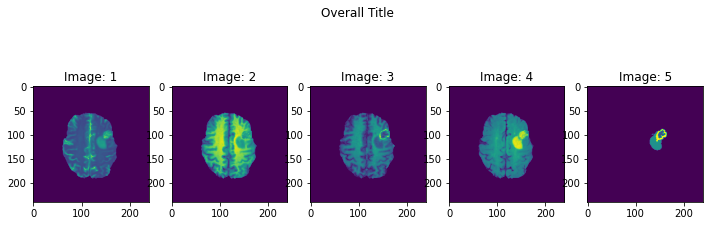

In [4]:
plot_observation(images, 0)

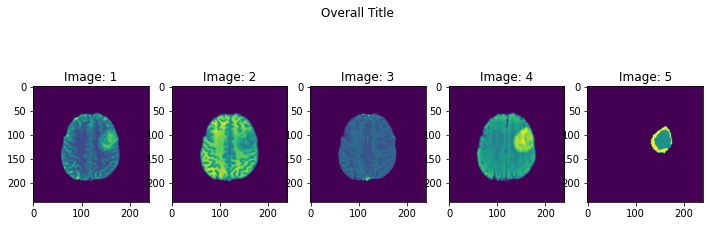

In [5]:
plot_observation(imagesl, 0)

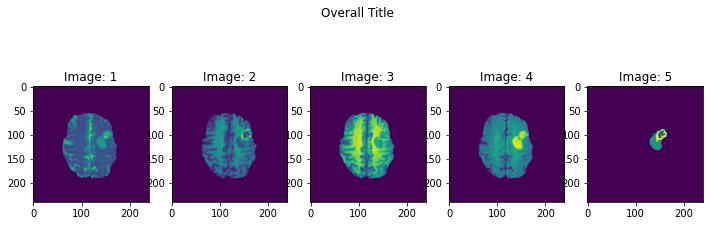

In [6]:
plot_observation(all_images, 0)

In [215]:
# type_to_use = 'flair'
# images_chosen = [Image.fromarray(np.uint8(cm.gist_earth(images[type_names.index(type_to_use)][i]/np.max(images[type_names.index(type_to_use)][i]+1))*255)[:, :, :3]) for i in range(len(images[type_names.index(type_to_use)]))]
# images_seg = [Image.fromarray(np.uint8(cm.gist_earth(images[type_names.index('seg')][i]/np.max(images[type_names.index('seg')][i]+1))*255)[:, :, :3]) for i in range(len(images[type_names.index('seg')]))]

In [359]:
type_to_use = 'flair'
images_chosen = np.array([images[type_names.index(type_to_use)][i] for i in range(len(images[type_names.index(type_to_use)]))])
images_seg = np.array([images[type_names.index(type_to_use)][i] for i in range(len(images[type_names.index(type_to_use)]))])

In [360]:
# type_to_use = 'flair'
# images_chosen = pad_sequence([torch.tensor(x.astype(np.int16)).unsqueeze(0).expand(3, -1, -1) for x in all_images[type_names.index(type_to_use)]], batch_first=True)
# images_seg = pad_sequence([torch.tensor(x.astype(np.int16)).unsqueeze(0).expand(3, -1, -1) for x in all_images[type_names.index('seg')]], batch_first=True)

In [361]:
# train_img, test_img = split_train_test_with_fract(images_tensors)
# train_seg, test_seg = split_train_test_with_fract(seg_tensors)

# dataset = {
#     'Train': {'image': train_img, 'masks': train_seg},
#     'Test': {'image': test_img, 'masks': test_seg}
#     }


# dataloaders = {
#         x: DataLoader(dataset[x],
#                       batch_size=10,
#                       #shuffle=True, #to test without shuffle not done yet
#                       #num_workers=8
#                       )
#         for x in ['Train', 'Test']
#     }

In [382]:
model = models.segmentation.deeplabv3_mobilenet_v3_large(
    pretrained=False,
    progress=True,
    num_classes = 3
)

In [383]:
class Custom_Dataset(Dataset):
    def __init__(self,
                 images_list,
                 seg_list,
                 fraction = 0.1,
                 subset = None,
                 transforms = None,
                 image_color_mode = "rgb",
                 mask_color_mode = "rgb") -> None:

        if image_color_mode not in ["rgb", "grayscale"]:
            raise ValueError(
                f"{image_color_mode} is an invalid choice. Please enter from rgb grayscale."
            )
        if mask_color_mode not in ["rgb", "grayscale"]:
            raise ValueError(
                f"{mask_color_mode} is an invalid choice. Please enter from rgb grayscale."
            )

        self.image_color_mode = image_color_mode
        self.mask_color_mode = mask_color_mode
        self.transforms = transforms

        if subset not in ["Train", "Test"]:
            raise (ValueError(
                f"{subset} is not a valid input. Acceptable values are Train and Test."
            ))
        self.fraction = fraction
        self.image_list = images_list
        self.mask_list = seg_list

    def __len__(self) -> int:
        return len(self.image_list)

    def __getitem__(self, index: int):
        image = self.image_list[index]
        mask = self.mask_list[index]
        
        sample = {"image": image, "mask": mask}
        # if self.transforms:
        #     sample["image"] = torch.tensor(sample["image"]).expand(3, -1, -1).type(torch.ShortTensor)
        #     sample["mask"] = torch.tensor(sample["mask"]).expand(3, -1, -1).type(torch.ShortTensor)
        sample["image"] = torch.tensor(sample["image"]).expand(3, -1, -1).type(torch.ShortTensor)
        sample["mask"] = torch.tensor(sample["mask"]).expand(3, -1, -1).type(torch.ShortTensor)
        return sample

In [384]:
data_transforms = transforms.Compose(
    [transforms.ToTensor(),
    ])

image_datasets = {
        x: Custom_Dataset(
            images_chosen,
            images_seg,
            transforms=None,
            subset=x)
        for x in ['Train', 'Test']
    }

dataloaders = {
        x: DataLoader(image_datasets[x],
                      batch_size=10,
                      #shuffle=True, #to test without shuffle not done yet
                      #num_workers=8
                      )
        for x in ['Train', 'Test']
    }

In [385]:
# path = Path(os.getcwd()) / 'data_extracted'
# type_to_use = 'flair'
# batch_size = 10

# dataloaders = get_dataloader_single_folder(
#         path, 
#         image_folder=type_to_use,
#         mask_folder='seg',
#         batch_size=batch_size)

# for i in iter(dataloaders['Train']):
#     print(i['mask'].type(torch.LongTensor).shape)

# for i in iter(dataloaders['Train']):
#     print(i['image'].squeeze().type(torch.LongTensor).shape)

In [390]:
import time
import copy
from tqdm import tqdm
from sklearn.metrics import f1_score

since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 1e10
metrics = {'f1_score': f1_score}
num_epochs = 2
#criterion = torch.nn.CrossEntropyLoss(reduction='mean')
criterion = torch.nn.MSELoss(reduction='mean')

# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# # Use gpu if available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)

# Initialize the log file for training and testing loss and metrics
fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
    [f'Train_{m}' for m in metrics.keys()] + \
    [f'Test_{m}' for m in metrics.keys()]

for epoch in range(1, num_epochs + 1):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
    batchsummary = {a: [0] for a in fieldnames}

    for phase in ['Train', 'Test']:
        if phase == 'Train':
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        # Iterate over data.
        for sample in tqdm(iter(dataloaders[phase])):
            inputs = sample['image'].float()
            masks = sample['mask'].float()
            # zero the parameter gradients
            optimizer.zero_grad()

            # track history if only in train
            with torch.set_grad_enabled(phase == 'Train'):
                outputs = model(inputs)
                loss = criterion(outputs['out'], masks)
                y_pred = outputs['out'].data.cpu().numpy().ravel()
                y_true = masks.data.cpu().numpy().ravel()
                for name, metric in metrics.items():
                    if name == 'f1_score':
                        # Use a classification threshold of 0.1
                        batchsummary[f'{phase}_{name}'].append(
                            metric(y_true > 0, y_pred > 0.1))
                    else:
                        batchsummary[f'{phase}_{name}'].append(
                            metric(y_true.astype('uint8'), y_pred))

                # backward + optimize only if in training phase
                if phase == 'Train':
                    loss.backward()
                    optimizer.step()
        batchsummary['epoch'] = epoch
        epoch_loss = loss
        batchsummary[f'{phase}_loss'] = epoch_loss.item()
        print('{} Loss: {:.4f}'.format(phase, loss))
    for field in fieldnames[3:]:
        batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        # deep copy the model
        if phase == 'Test' and loss < best_loss:
            best_loss = loss
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Lowest Loss: {:4f}'.format(best_loss))

# load best model weights
model.load_state_dict(best_model_wts)

Epoch 1/2
----------


100%|██████████| 26/26 [02:26<00:00,  5.65s/it]


Train Loss: 19074.1660


100%|██████████| 26/26 [00:48<00:00,  1.86s/it]


Test Loss: 19133.4102
{'epoch': 1, 'Train_loss': 19074.166015625, 'Test_loss': 19133.41015625, 'Train_f1_score': 0.8316794754506646, 'Test_f1_score': [0, 0.8847107855892175, 0.9048612595374526, 0.8635418185897795, 0.8857699451818963, 0.872419367325409, 0.8961811412783219, 0.8595911154337967, 0.9012906436789385, 0.901129679983508, 0.8931463532464198, 0.8945795442653109, 0.8997586254192403, 0.8815659255912415, 0.911261066171163, 0.8704270965702818, 0.8773574945982024, 0.8678907141454069, 0.8782535572225633, 0.8707101494805279, 0.8765146049488409, 0.914128157802362, 0.9013613224594209, 0.8985226581087811, 0.8656139343477844, 0.8994192032877641, 0.8921635995932915]}
{'epoch': 1, 'Train_loss': 19074.166015625, 'Test_loss': 19133.41015625, 'Train_f1_score': 0.8316794754506646, 'Test_f1_score': 0.8541544356984047}
Epoch 2/2
----------


100%|██████████| 26/26 [02:19<00:00,  5.37s/it]


Train Loss: 18982.5039


100%|██████████| 26/26 [00:52<00:00,  2.01s/it]

Test Loss: 19047.9395
{'epoch': 2, 'Train_loss': 18982.50390625, 'Test_loss': 19047.939453125, 'Train_f1_score': 0.8376466046593106, 'Test_f1_score': [0, 0.8594117698518926, 0.8749701546794236, 0.8463443032367862, 0.8673790248622456, 0.8650952836370721, 0.8717319947841325, 0.834574021242795, 0.8877013217560867, 0.8900401402991718, 0.8704716964988535, 0.8783760048924695, 0.8877815765864068, 0.8634251455842208, 0.8890683560977904, 0.851862696021484, 0.8796753258491965, 0.8519931751202109, 0.8595425587688592, 0.8446061445812941, 0.855315584778172, 0.8982142953859819, 0.8869423828947397, 0.8805653756844939, 0.8483633233897762, 0.8631998106220727, 0.8741260060192757]}
{'epoch': 2, 'Train_loss': 18982.50390625, 'Test_loss': 19047.939453125, 'Train_f1_score': 0.8376466046593106, 'Test_f1_score': 0.8363250915972187}
Training complete in 6m 28s
Lowest Loss: 19047.939453


<All keys matched successfully>

In [394]:
model_exp_name = 'flair_totalpipe_final'
torch.save(model, str(Path(os.getcwd()) / 'models' / (model_exp_name + '.pt')))

In [396]:
modelname = 'flair_totalpipe_final.pt'
model = torch.load(Path(os.getcwd()) / 'models' / modelname)
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),

In [412]:
input_tensor = torch.tensor(images[type_names.index(type_to_use)][0]).expand(3, -1, -1).type(torch.ShortTensor).float()

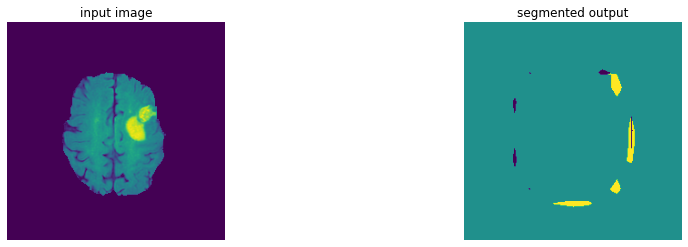

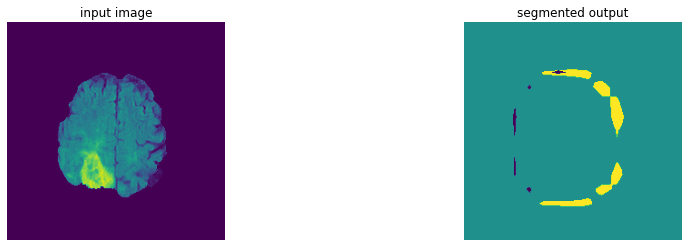

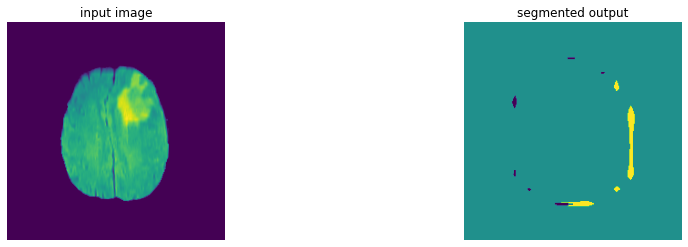

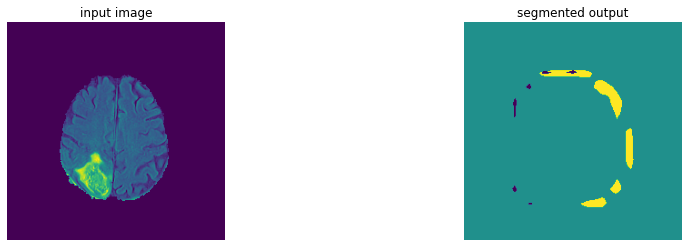

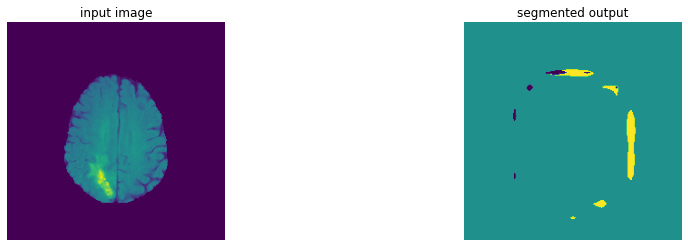

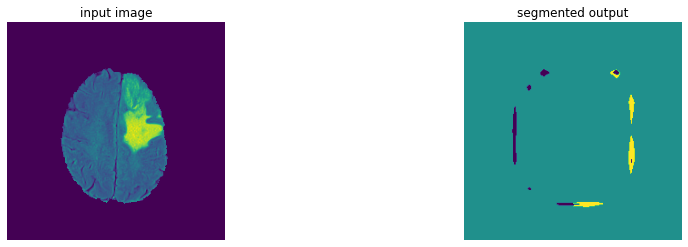

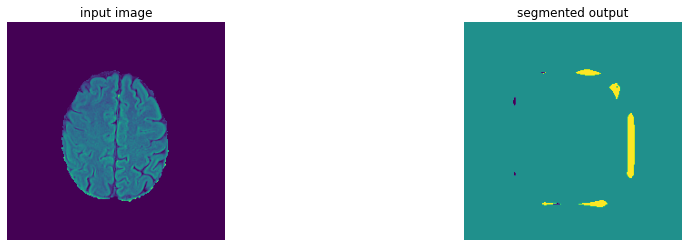

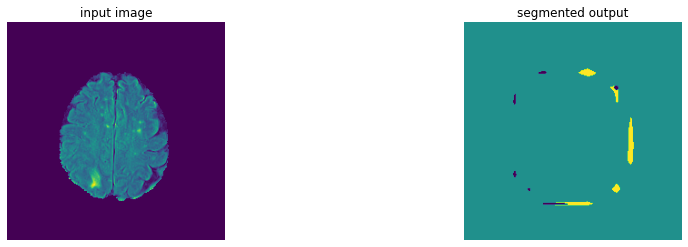

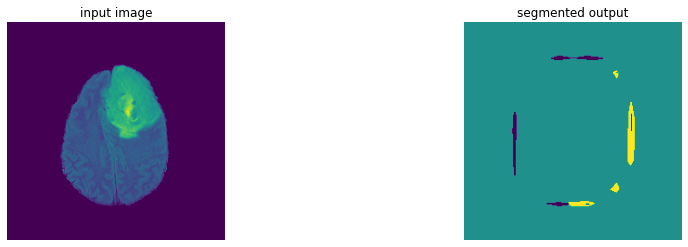

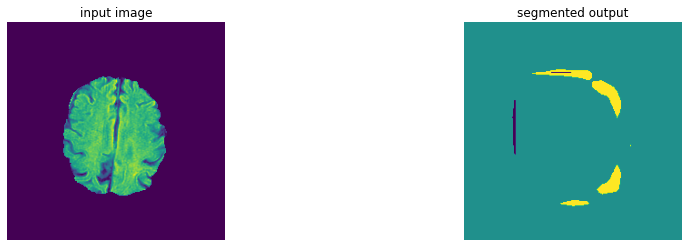

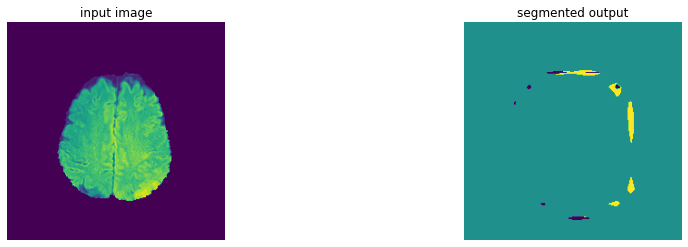

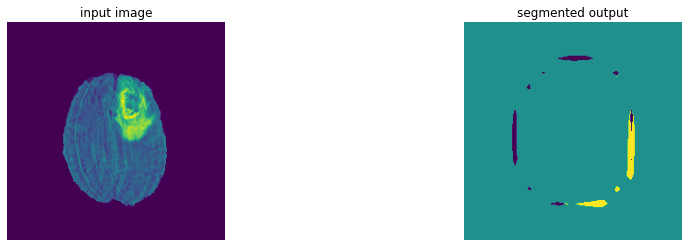

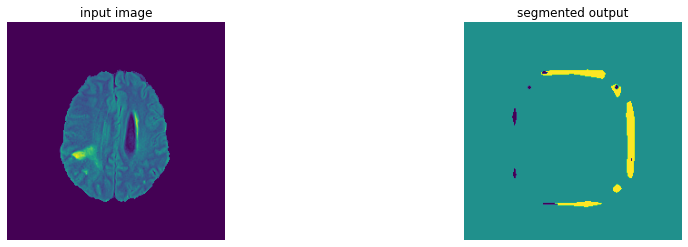

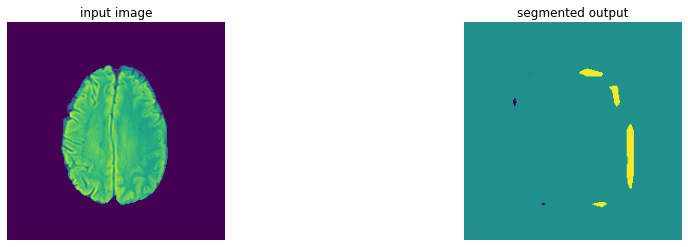

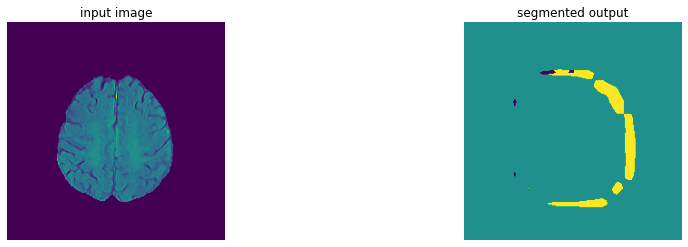

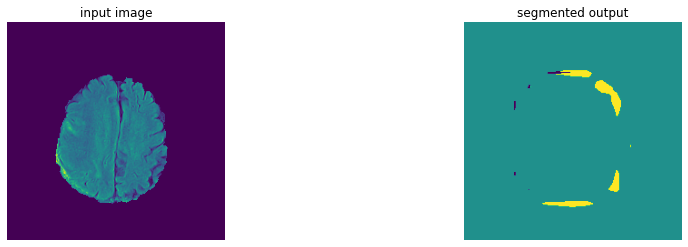

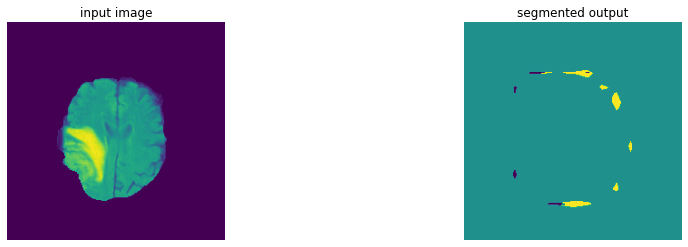

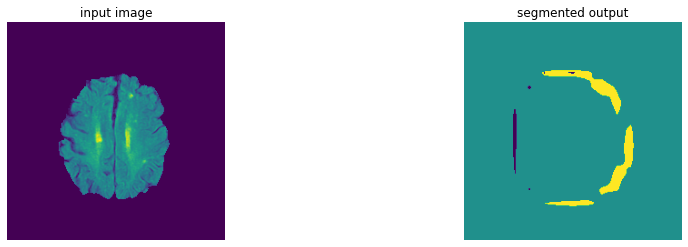

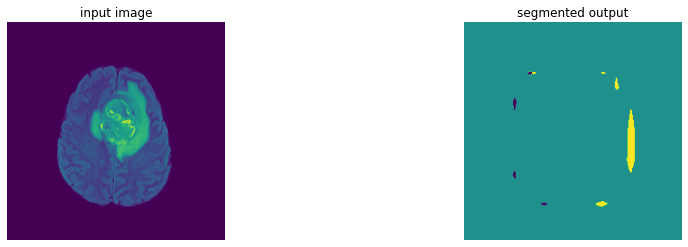

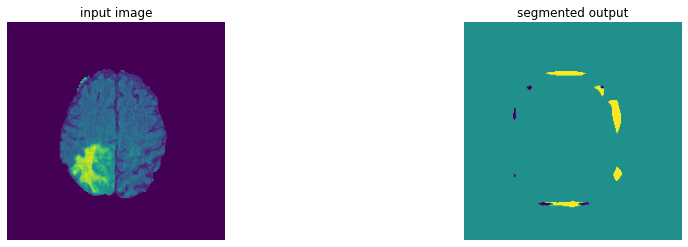

In [427]:
indexes_predict = np.arange(0, 20)

for i in indexes_predict:
    input_tensor = torch.tensor(images[type_names.index(type_to_use)][i]).expand(3, -1, -1).type(torch.ShortTensor).float()

    input_batch = input_tensor.unsqueeze(0) 

    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)

    # create a color pallette, selecting a color for each class
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")

    # r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_tensor.size)
    # r.putpalette(colors)

    f, ax = plt.subplots(1, 2, figsize=(15, 4))
    ax[0].set_title('input image')
    ax[0].axis('off')
    ax[0].imshow(input_tensor[0])
    ax[1].set_title('segmented output')
    ax[1].axis('off')
    plt.imshow(output_predictions)
    #plt.savefig("segmented_output.png", bbox_inches='tight')
    plt.show()